## Mixture Density Networks - Regression 

The **goal** of this notebook is twofold: (i) explain the theory and implementation of Mixture Density Networks (MDN) and (ii) its application in regression problems

In particular, we are interested in study MDN as a promising solution for some of the problems presented in ['On-the-fly' technique](https://github.com/beeva/TEC_LAB-bayesian_probabilistic/tree/master/bayesian_deep_learning/uncertainty_estimation#1---al-vuelo): 
 * (i) Inability to model more complex distributions: multi-modal, assymetric, long-tail, etc.
 * (ii) Difficulty to model the prior and the parameter estimation (loss function): the gaussian distribution is easy to compute, however other distributions may require some mathematical approximation.  
 
 

**Notebook sections**

 *  Introduction to Mixture Density Networks.
 *  Application to regression: (i) Synth. data of Exp.I (ii) Boston dataset.
 *  Conclusions.

#### Imports

In [2]:
import os
import numpy as np
import pandas as pd

from sklearn.datasets import load_boston

import tensorflow as tf
import tensorflow.keras as K
from tensorflow_probability import distributions as tfd
from tensorflow.keras.layers import Input, Dense, Activation, Concatenate
#from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_palette(sns.color_palette('Blues'))
dot_color = sns.color_palette('coolwarm', 6)[1] # Set dots to a light gray
mpl.rcParams['figure.figsize'] = 20, 10

%matplotlib inline
np.random.seed(2019)

### Introduction to Mixture Density Networks

The [mixture density networks (Bishop, 1994)](https://publications.aston.ac.uk/id/eprint/373/1/NCRG_94_004.pdf) are a class of models obtained by combining a conventional neural network with a [mixture density model](https://en.wikipedia.org/wiki/Mixture_model). This method allow us to estimate a conditional [mixture distribution](https://en.wikipedia.org/wiki/Mixture_distribution) of the target.

The probability density of the target data is then represented as a linear combination of the kernel functions $\phi_i$  with the following formula:

$$p(\boldsymbol{y} | \boldsymbol{x} ) = \sum_{i=1}^m \alpha_i (\boldsymbol{x}) \phi_i (\boldsymbol{y} |  x_m , \lambda_i ... )$$

*Formula parameters* 

* $m$ corresponds to the index of the corresponding mixture. There are up to $m$ mixture components (distributions) per output, being a selectable parameter.
* $\alpha$ is the mixing coefficient. To understand this coefficient, we can imagine the sliders that control the mix of $m$ different audio outputs. This parameter is conditioned by the input x.
* $\phi_i$ this is the corresponding input distribution to be mixed. The distribution selection is an explicit prior of the model and it can be chosen according to the type of application. 
* $\lambda$ are the parameters of the $\phi_i$ distribution. In the case we denote $\phi_i$ as a Gaussian distribution, these parameters would correspond to λ1 would be the mean conditional mean μ (x) and λ2 the standard deviation σ (x). The distributions can have different number of parameters (eg: Bernoulli and Chi2 have 1 parameter, Beta has 2, and the truncated Gaussian has up to 4 parameters). These are parameters that also form the output of the network.

*Parameter estimation*

The problem that arises when estimating the distribution of $p(\boldsymbol{y} | \boldsymbol{x} )$ is that, on the one hand, we do not even know the different processes that generate these sub-populations nor to which sub-population a specific observation belongs. For this reason we compute the log-likelihood and apply the [MLE (Maximum Likelihood Estimation) algorithm](https://towardsdatascience.com/gaussian-mixture-models-and-expectation-maximization-a-full-explanation-50fa94111ddd).

Following this approximation with defined the loss function to minimize the log-likelihood as follows:

$$ \log \mathcal{L}(\boldsymbol{y} \mid \boldsymbol{x}) = - \log \left( p(\boldsymbol{y} \mid \boldsymbol{x}) \right) = - \log \left(\overset{m}{\underset{i=0}{\sum}} \alpha_i (\boldsymbol{x}) \phi_i (\boldsymbol{y} | \boldsymbol{x} ) \right) $$

### Application to regression

#### Implementation details of MDN

In this notebook, we will use an implementation of a MDN with Gaussian family of distribution, this model is also called GMM (Gaussian Mixture Model). 

*Network Properties*

* *MDN - hyperparameters*: $\phi_i$ distribution family, $m$ mixture components.
* *Network input*: (i) regression synth data (ii) boston dataset 
* *Network output*: $\alpha$ mixing coefficient, parameters of the distribution ( e.g. gaussian --> $\mu$ mean, $\lambda$ standard deviation)

*Note: For the implementation of the MDN has be taken the reference: https://towardsdatascience.com/a-hitchhikers-guide-to-mixture-density-networks-76b435826cca. However, other implementaions may be valid.*

*Note: Here, we use the Gaussian distribution as example, but other distributions families may be valid. See: [Tensorflow Probability documentation](https://www.tensorflow.org/probability)*

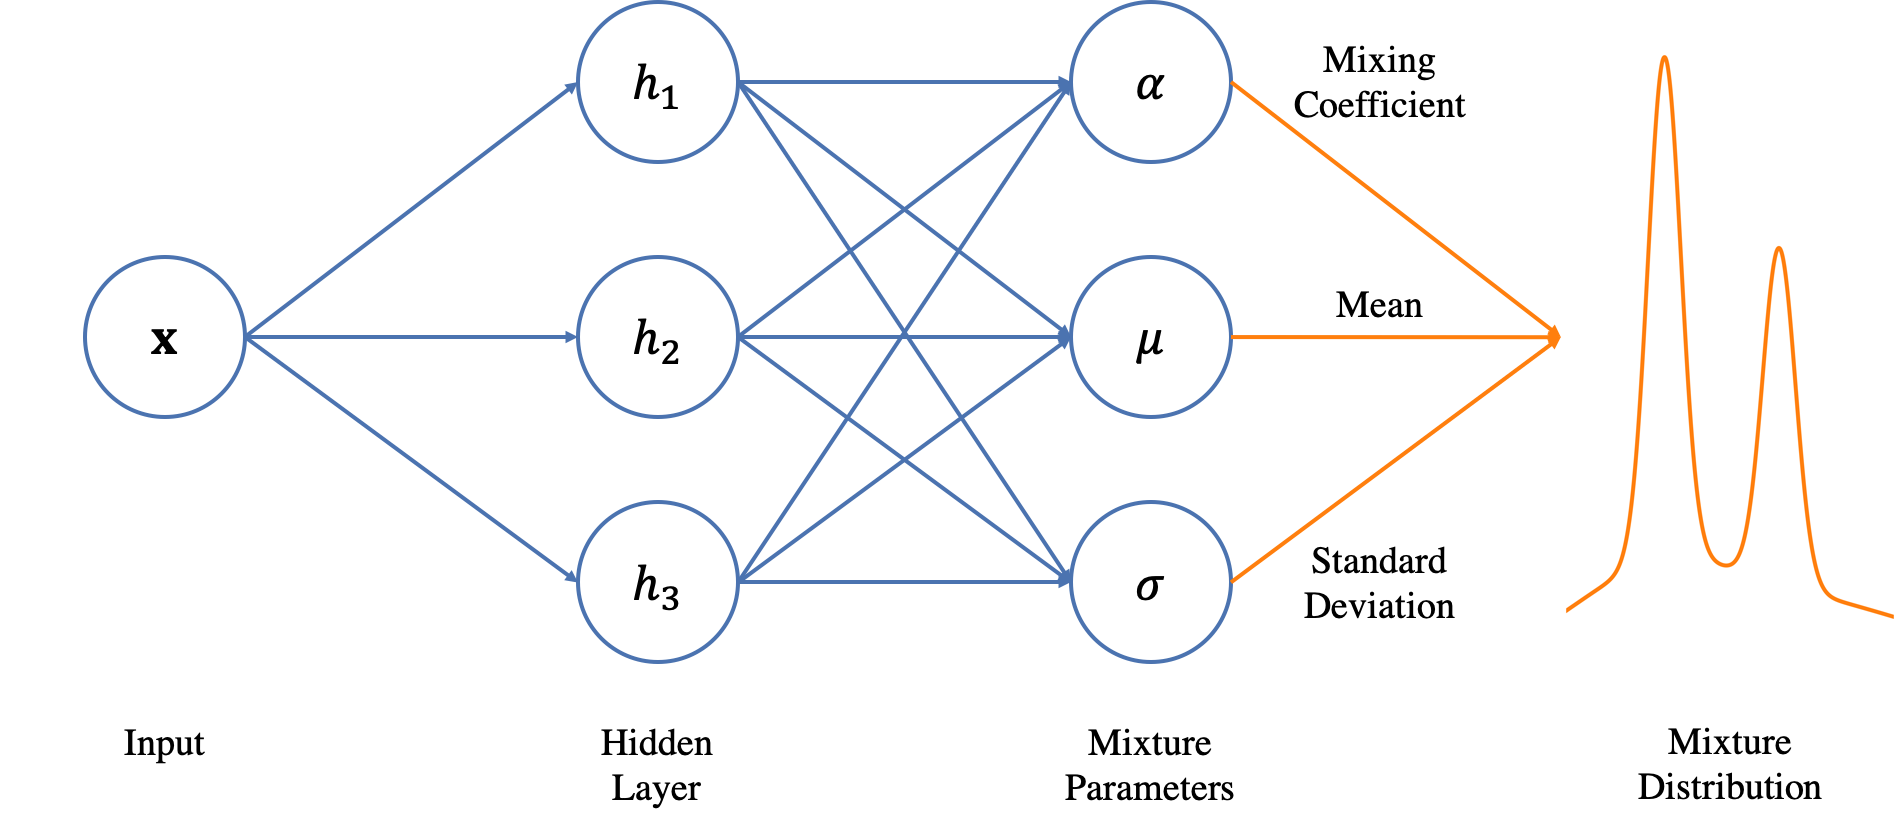

In [3]:
from IPython.display import Image
Image("../../img/MDN.png", width = 700, height = 400)

We define a MDN with 2 hidden layers (initialized with 1000 neurons as default) and the 3 outputs as defined before ($\alpha$,  $\mu$, $\lambda$). The parameter output may vary depending on the family distribution. 

In [4]:
class MDN(tf.keras.Model):

    def __init__(self, neurons=1000, components = 2):
        super(MDN, self).__init__(name="MDN")
        self.neurons = neurons
        self.components = components
        
        self.h1 = Dense(neurons, activation="relu", name="h1")
        self.h2 = Dense(neurons, activation="relu", name="h2")
        
        self.alphas = Dense(components, activation="softmax", name="alphas")
        self.mus = Dense(components, name="mus")
        self.sigmas = Dense(components, activation="nnelu", name="sigmas")
        self.pvec = Concatenate(name="pvec")
        
    def call(self, inputs):
        x = self.h1(inputs)
        x = self.h2(x)
        
        alpha_v = self.alphas(x)
        mu_v = self.mus(x)
        sigma_v = self.sigmas(x)
        
        return self.pvec([alpha_v, mu_v, sigma_v])

*Note: we return a vectorized version of the parameter vector as the output of the MDN network. Thus, we will need to unpack the parameters in the prediction results.*

#### Custom (auxiliar) functions

We have three custom auxiliar functions:
  * **nnelu**: A custom activation function.
  * **slice_parameter_vectors**: It is required to unpack the parameters output/predictions of the defined MDN network.
  * **gnll_loss**: It computes the mean negative log-likelihood loss so we apply MLE for parameter optimization.

*nnelu function*

In [5]:
def nnelu(input):
    """ Computes the Non-Negative Exponential Linear Unit
    """
    return tf.add(tf.constant(1, dtype=tf.float32), tf.nn.elu(input))


tf.keras.utils.get_custom_objects().update({'nnelu': Activation(nnelu)})

We define a custom activation Non-Negative Exponential Linear Unit for the sigma parameter in order to speed up the training. This activation function is similar to [ELU](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html) but we don't allow negative outputs.

*Note: we call get_custom_objects() to register this custom function as a custom object in Keras and be able to properly reference this function with its alias 'nnelu'*

*slice_parameter_vectors function*

In [6]:
def slice_parameter_vectors(parameter_vector):
    """ Returns an unpacked list of parameter vectors.
    """
    return [parameter_vector[:,i*components:(i+1)*components] for i in range(no_parameters)]

We use the function slice_parameter_vectors to split a compound vector with the parameters of the choosen family distribution. In this case sigma and mu.

*gnll_loss function*

In [7]:
def gnll_loss(y, parameter_vector):
    """ Computes the mean negative log-likelihood loss of y given the mixture parameters.
    """
    alpha, mu, sigma = slice_parameter_vectors(parameter_vector) # Unpack parameter vectors
    
    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
    
    log_likelihood = gm.log_prob(tf.transpose(y)) # Evaluate log-probability of y
    
    return -tf.reduce_mean(log_likelihood, axis=-1)

Here, we defined the loss function to minimized log-likelihood as it has been explained in the introductory section. We use the function [MixtureSameFamily from tensorflow](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/MixtureSameFamily).

### (i) Synth. data of Exp.I

Once that we have defined our networks, we train a regression model with 2 different regression synthetic datasets:

--- Test 1 ---

First, we train a model with the same synthetic data of On-the-fly [previous experiments](https://github.com/beeva/TEC_LAB-bayesian_probabilistic/blob/master/bayesian_deep_learning/uncertainty_estimation/on-the-fly/pytorch/01-initial_validation/initial_validation.ipynb). See the reference notebook for detailed explanations of this dataset.

--- Test 2 ---

Secondly, we perform a second test but modifying the previous synthetic data for generating two well differentiated non-linear sinusoidal sources. We seek to be able to discriminate these two different sources with MDN and predict a multimodal distribution.

#### ---  Test 1 - Generate same synthetic data of On-the-fly 

See the [reference notebook](https://github.com/beeva/TEC_LAB-bayesian_probabilistic/blob/master/bayesian_deep_learning/uncertainty_estimation/on-the-fly/pytorch/01-initial_validation/initial_validation.ipynb) previous experiments for detailed explanations of this dataset.

In [9]:
# Generate some linearly related data
n_samples = 10000
x_ = np.random.random(n_samples)

sin_ = 0.4 * np.sin(x_*4*np.pi)
eps = np.random.normal(scale=1.0, size=n_samples) * sin_ # noise
y_1 = 2*x_ + 1 
y_ = y_1 + eps # linear data with noise

#### Validation and training

In [10]:
# Split into training and validation sets
n_validation = 800
x_val, x_train = x_[:n_validation].reshape(-1,1), x_[n_validation:].reshape(-1,1)
y_val, y_train = y_[:n_validation].reshape(-1,1), y_[n_validation:].reshape(-1,1)

In [11]:
x_train.shape, x_val.shape

((9200, 1), (800, 1))

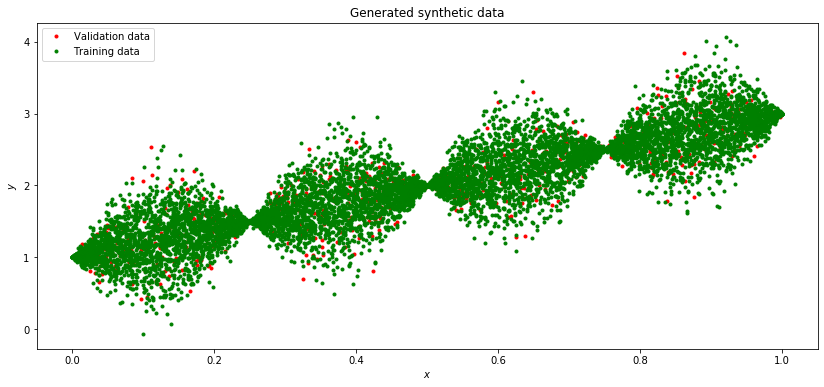

In [12]:
# Plot the data
plt.figure(figsize=(14,6))
plt.title('Generated synthetic data')

# plot data (with and without noise addition) 
plt.plot(x_val, y_val, '.', color='red' ) 
plt.plot(x_train, y_train,  '.', color='green' ) 

plt.legend([r'Validation data',r'Training data'])
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

This dataset represents a good easy sceneario for showing the application of MDN. The dataset is generated with a simple linear function with gaussian sinusoidal noise.

We take 800 points for validation purpose. The total number of datapoints in the test is 10000.

#### MDN Model training

#### Hyper-parameters selection

Here, we compute a MDN with 3 components or Gaussian Kernels. At least 2 components are necessary to be able to estimate a multimodal distribution of P(Y|X)

In [13]:
no_parameters = 3


components = 3
neurons = 200

opt = tf.optimizers.Adam(1e-3)

#tf_path = os.path.join(os.getcwd(), 'tf_board')
#tensorboard = TensorBoard(log_dir=tf_path, histogram_freq=0, write_graph=True, write_images=False)
#mon = EarlyStopping(monitor='val_loss', baseline=-0.1, mode='min')

In [14]:
mdn = MDN(neurons=neurons, components=components)
mdn.compile(loss=gnll_loss, optimizer=opt)

In [15]:
x_train.shape, x_val.shape

((9200, 1), (800, 1))

#### Train the MDN with the synthetic generated data

We train a simple neural network with 200 neurons and 2 dense layers. The aim of this notebook is to keep the complexity of the network simple to check how easily is to overfit the network to the dataset

In [16]:
%%time
#mdn.fit(x=x_train, y=y_train, epochs=1000, validation_data=(x_val, y_val), callbacks=[tensorboard], batch_size=128, verbose=0)
mdn.fit(x=x_train, y=y_train, epochs=1000, validation_data=(x_val, y_val), batch_size=128, verbose=0)

CPU times: user 18min 15s, sys: 13min 55s, total: 32min 11s
Wall time: 8min 5s


#### Get predictions for validation set

We need to unpack the paremeters of the output with the auxiliar function defined before 'slice_parameter_vectors'

In [17]:
y_pred = mdn.predict(x_val)
alpha_pred, mu_pred, sigma_pred = slice_parameter_vectors(y_pred)

We predict 800 points with 3 sigmas per each point. As we have selected 3 gaussian kernels

In [18]:
sigma_pred.shape # 

(800, 3)

#### Plot results

We plot the prediction results. We have sigma and mu predicted for 3 different guassian kernels (red, green and yellow).

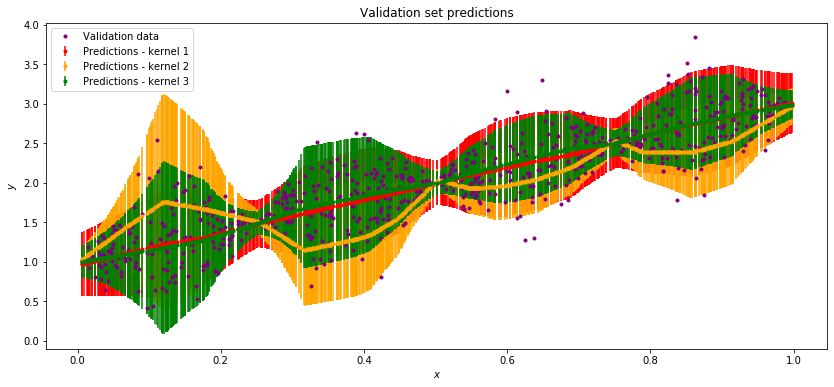

In [19]:
# Plot predictions and their errors
fig, ax1 = plt.subplots(figsize=(14,6))
ax1.plot(x_val, y_val, '.', color='purple')
ax1.errorbar(x_val, mu_pred[:,0], yerr=np.sqrt(sigma_pred[:,0]) , color='red', fmt='.'); 
ax1.errorbar(x_val, mu_pred[:,1], yerr=np.sqrt(sigma_pred[:,1]) , color='orange', fmt='.'); 
ax1.errorbar(x_val, mu_pred[:,2], yerr=np.sqrt(sigma_pred[:,2]) , color='green', fmt='.'); 

# One standard-deviation envelope
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.title('Validation set predictions');
plt.legend([r'Validation data','Predictions - kernel 1', 'Predictions - kernel 2', 'Predictions - kernel 3'], loc='upper left', );
plt.show()

As we can see in this plot, we have been able to predict the variance of the predictions with three gaussian kernels.

Nevertheless, the network is prone to overfitting (there are predictions that clearly follow noisy patterns), the net is learning from noisy data. This cause generalization problems.
It might be solved reducing using the kernel size with only 1 or 2 gaussian kernels. However, these tests that are out-of-scope of this notebook.

#### Compound the output mixture distribution

Here, we choose as an example the input point=0.9 to show how we can compound the final output distribution using the estimated parameter of each gaussian.

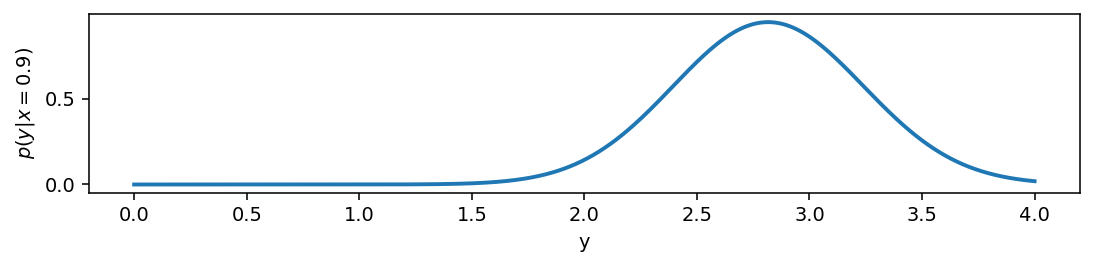

In [20]:
x_value = 0.9

alpha, mu, sigma = slice_parameter_vectors(mdn.predict([x_value]))

gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))

x = np.linspace(0,4,int(1e4))
pyx = gm.prob(x)

fig = plt.figure(figsize=(8,2), dpi=140)
ax = plt.gca()

ax.plot(x, pyx, alpha=1, color=sns.color_palette()[0], linewidth=2)

ax.set_xlabel(r"y")
ax.set_ylabel(r"$p(y|x=" + str(x_value)+ ")$")

plt.tight_layout()
plt.show()

This plot represents the likelihood estimation of y for the point Xi=0.9. The sum of the three gaussian kernels.

-------

*How can we get an uni-modal distribution if we have three well differentiated distrbutions/source outputs (plotted in different colors in the first figure)?*

In [21]:
alpha

array([[0.9732666 , 0.01726972, 0.00946368]], dtype=float32)

Here, we have printed the mixed coeffficients $\alpha$ of the three different predicted gaussian kernels. As we can notice, the only one identified as relevant is the third gaussian kernel (plotted in green - first figure) with  $\alpha_1$ = 0.973.  

#### ---  Test 2 - Generate non-linear synthetic data

Here, we generate two well differentiated non-linear sinusoidal sources. We seek to be able to discriminate these two different sources with MDN and predict a multimodal distribution.

- The first source is generated following a *positive* sinusoidal form with uniform noise.
- The second source is gnereated following a *negative* sinusoidal form with uniform noise.

Finally, we compound the final dataset as the aggregation of the data points of source 1 and source 2.

In [272]:
n_samples = 10000 # total data points

### source 1
n_samples_1 = int(n_samples/2)
x_1_ = np.random.random(n_samples_1)
sin_1_ = 0.4 * np.sin(x_1_*4*np.pi)

eps_2 = np.float32(np.random.uniform(0, 0.5, (1, n_samples_1))) + sin_1_ # noise
y_1_ = 2* x_1_ + 1 
y_1 = y_1_ + eps_2[0]

### source 2
n_samples_2 = int(n_samples/2)
x_2_ = np.random.random(n_samples_2)
sin_2_ = 0.4 * np.sin(x_2_*4*np.pi)

eps_3 = np.float32(np.random.uniform(0, 0.5, (1, n_samples_2))) + -sin_2_ # noise
y_2_ = 2* x_2_ + 1 
y_2 = y_2_ + eps_3[0]

## Concatenate the two data sources
x_data = np.concatenate((x_1_,x_2_), axis=0).T
y_data = np.concatenate((y_1,y_2), axis=0).T

#### Validation and training

We split the dataset in validation and training. We choose 9200 for training and 800 for validation. 

In [334]:
# Split into training and validation sets
n_validation = 9200 

indices = np.random.permutation(x.shape[0])
training_idx, test_idx = indices[:n_validation], indices[n_validation:]

x_val_2, x_train_2 = x_data[test_idx].reshape(-1,1), x_data[training_idx].reshape(-1,1)
y_val_2, y_train_2 = y_data[test_idx].reshape(-1,1), y_data[training_idx].reshape(-1,1)

In [335]:
x_train_2.shape , x_val_2.shape

((9200, 1), (800, 1))

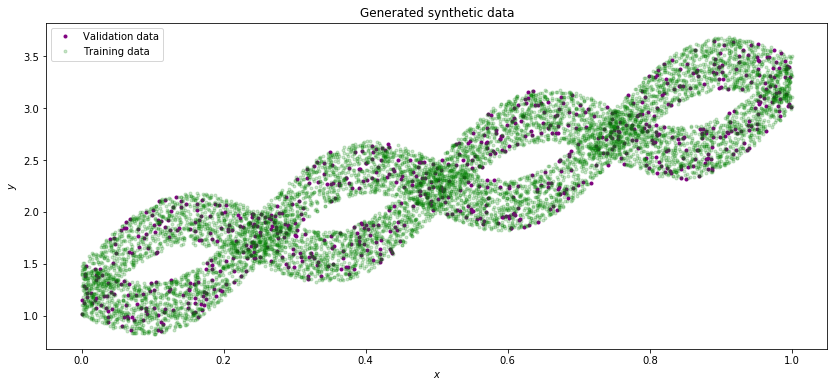

In [336]:
# Plot the data
plt.figure(figsize=(14,6))
plt.title('Generated synthetic data')

plt.plot(x_val_2, y_val_2, '.', color='purple' ) 
plt.plot(x_train_2, y_train_2, '.', alpha=0.2, color='green' ) 

plt.legend([r'Validation data',r'Training data', r'$\mu$', r'$\pm\sigma$'])
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

As we can see in this plot, we have two well differentiated sinusoidal sources. We expect that with the same network definition (3 gaussian kernels) to be able to predict these two different sources.

#### Model training

We train the same architecture as before: a simple neural network with 200 neurons and 2 dense layers. We keep the number of components (or k-distributions) to three.

In [337]:
components = 3
neurons = 200

opt = tf.optimizers.Adam(1e-3)

mdn_test2 = MDN(neurons=neurons, components=components)
mdn_test2.compile(loss=gnll_loss, optimizer=opt)

In [339]:
%%time
#mdn.fit(x=x_train, y=y_train, epochs=1000, validation_data=(x_val, y_val), callbacks=[tensorboard], batch_size=128, verbose=0)
mdn_test2.fit(x=x_train_2, y=y_train_2, epochs=1000, validation_data=(x_val_2, y_val_2), batch_size=128, verbose=0)

CPU times: user 15min 59s, sys: 11min 25s, total: 27min 25s
Wall time: 7min 12s


#### Get predictions

In [341]:
y_pred_test2  = mdn_test2.predict(x_val)
alpha_pred_test2 , mu_pred_test2 , sigma_pred_test2 = slice_parameter_vectors(y_pred_test2)

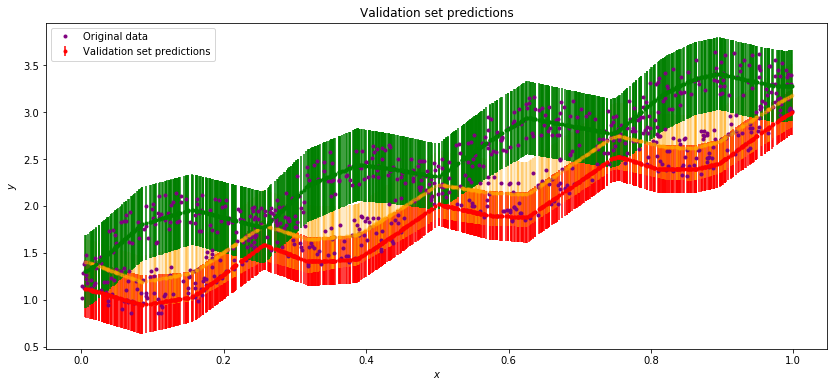

In [356]:
# Plot predictions and their errors

fig, ax1 = plt.subplots(figsize=(14,6))
ax1.plot(x_val_2, y_val_2, '.', color='purple')
ax1.errorbar(x_val, mu_pred_test2[:,0], yerr=np.sqrt(sigma_pred_test2[:,0]) , color='red', fmt='.'); 
ax1.errorbar(x_val, mu_pred_test2[:,1], yerr=np.sqrt(sigma_pred_test2[:,1]) , alpha=0.3, color='orange', fmt='.'); 
ax1.errorbar(x_val, mu_pred_test2[:,2], yerr=np.sqrt(sigma_pred_test2[:,2]) , color='green', fmt='.'); 


# One standard-deviation envelope
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.title('Validation set predictions');
plt.legend([r'Original data','Predictions - kernel 1', 'Predictions - kernel 2', 'Predictions - kernel 3'], loc='upper left', );

As we can see in this plot, we have been able to predict the variance of the predictions with three gaussian kernels.

However, introducing one extra kernel has affected the predictions of the second source (yellow and red points). In real applications, we don't know neither the number of sources nor the distributions. We must be careful and properly test different hyperparameter to avoid overfitting the model.

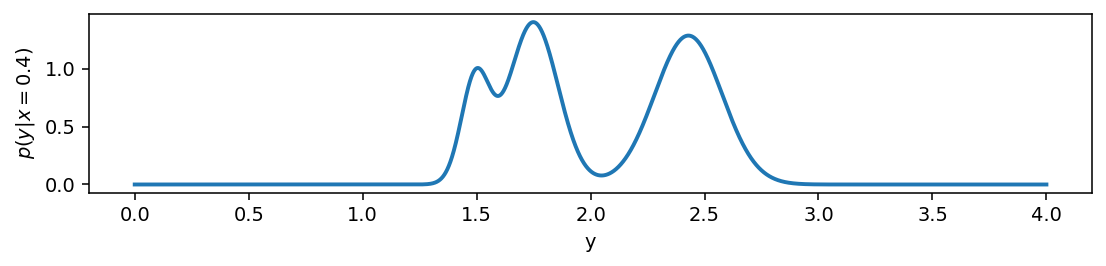

In [354]:
pto = 0.4

alpha_pred_test2_pto , mu_pred_test2_pto , sigma_pred_test2_pto = slice_parameter_vectors(mdn_test2.predict([pto]))

gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha_pred_test2_pto),
        components_distribution=tfd.Normal(
            loc=mu_pred_test2_pto,       
            scale=sigma_pred_test2_pto))

x = np.linspace(0,4,int(1e4))
pyx = gm.prob(x)

fig = plt.figure(figsize=(8,2), dpi=140)
ax = plt.gca()

ax.plot(x, pyx, alpha=1, color=sns.color_palette()[0], linewidth=2)

ax.set_xlabel(r"y")
ax.set_ylabel(r"$p(y|x=" + str(pto)+ ")$")

plt.tight_layout()
plt.show()

As we can see in this plot, we have been able to model a multi-modal distribution corresponding to the two different sources (compounding a non-linear function). Although, as explained before we have overfitted the data in the first source having two modes (it should be only mode per distribution - we only have two sinusoidals with uniform distribution noise).

### (ii) Application in Boston dataset

Here, we use the boston dataset of [previous experiments](https://github.com/beeva/TEC_LAB-bayesian_probabilistic/blob/master/bayesian_deep_learning/uncertainty_estimation/quantile_regression/experiments/01-quantile_regression/01-quantile_regression_techniques.ipynb). See the reference notebook for detailed explanations of this dataset.

In [542]:
boston_dataset = load_boston()

In [543]:
boston_dataset.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [544]:
print(boston_dataset.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [555]:
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [556]:
boston['MEDV'] = boston_dataset.target

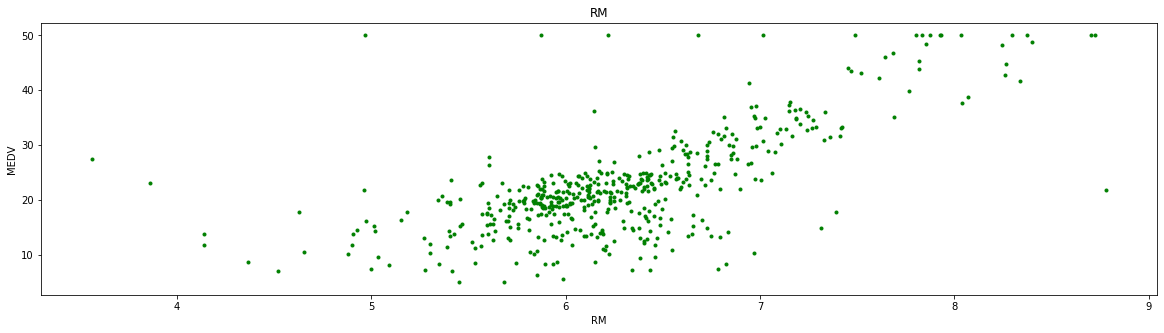

In [557]:
plt.figure(figsize=(20, 5))

features = ['RM']
target = boston['MEDV']

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = boston[col]
    y = target
    plt.plot(x, y, '.', color= 'green')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('MEDV')

In this plot, we can see a **clear correlation of the variables LSTAT and RM**. We found a negative correlation between MEDV and LSTAT and a positive correlation RM and MEDV. Additionally, we can observe that **both variables are heterocedastic with respect to MEDV**

#### Prepare data for training

Here, we will split the dataset and use 20% for testing

In [558]:
boston['MEDV'].size, boston['DIS'].size

(506, 506)

In [559]:
Y = pd.DataFrame(np.array([boston['MEDV']]).T, columns = ['y'])
X = pd.DataFrame(np.array([boston['RM']]).T, columns = ['RM'])

In [560]:
# Split into training and validation sets
from sklearn.model_selection import train_test_split
x, x_val, y, y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

In [561]:
x_train, x_val, y_train, y_val = x.values, x_val.values, y.values, y_val.values

In [562]:
x_tr_aleatoric = np.append(np.random.uniform(7, 9, 60), np.random.uniform(6.5, 7.5, 90))
y_tr_aleatoric =  np.append(np.random.uniform(5, 50, 60) , np.random.uniform(5, 50, 90))
y_tr_aleatoric =  np.append(y_tr_aleatoric, np.random.uniform(30, 45, 90))
x_tr_aleatoric =  np.append(x_tr_aleatoric, np.random.uniform(6.5, 9, 90))

y_tr_aleatoric =  np.append(y_tr_aleatoric, np.random.uniform(10, 20, 90))
x_tr_aleatoric =  np.append(x_tr_aleatoric, np.random.uniform(4, 6, 90))

y_tr_aleatoric =  np.append(y_tr_aleatoric, np.random.uniform(25, 35, 90))
x_tr_aleatoric =  np.append(x_tr_aleatoric, np.random.uniform(5.5, 7, 90))

y_tr_aleatoric =  np.append(y_tr_aleatoric, np.random.uniform(10, 20, 120))
x_tr_aleatoric =  np.append(x_tr_aleatoric, np.random.uniform(6.5, 9, 120))



x_test_aleatoric = np.append(np.random.uniform(7, 9, 40), np.random.uniform(6.5, 7.5, 60))
y_test_aleatoric = np.append(np.random.uniform(5, 20, 40) , np.random.uniform(5, 30, 60))

x_train = np.append(x_train, x_tr_aleatoric)
y_train = np.append(y_train, y_tr_aleatoric)

x_val =  np.append(x_val, x_test_aleatoric)
y_val = np.append(y_val, y_test_aleatoric)

In [563]:
y_train.size, x_train.size, x_val.size, y_val.size

(944, 944, 202, 202)

Text(0, 0.5, 'Median value of owner-occupied homes in $1000s')

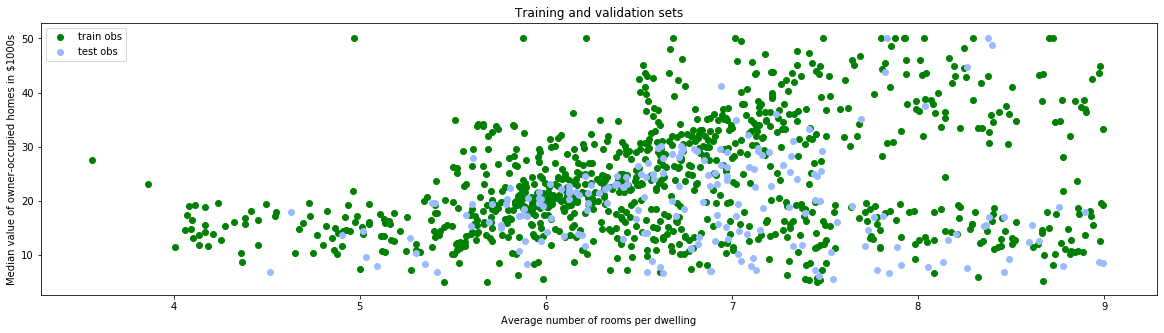

In [564]:
# Plot the data
plt.figure(figsize=(20, 5))
plt.scatter(x_train, y_train, color= 'green')
plt.scatter(x_val, y_val, color= dot_color)
plt.legend([r'train obs', 'test obs'], loc='upper left', );
plt.title('Training and validation sets')
plt.xlabel('Average number of rooms per dwelling')
plt.ylabel('Median value of owner-occupied homes in $1000s')

#### hypter-parameters selection

In [565]:
no_parameters = 3
components = 2
neurons = 200
opt = tf.optimizers.Adam(1e-3)

#tf_path = os.path.join(os.getcwd(), 'tf_board')
#tensorboard = TensorBoard(log_dir=tf_path, histogram_freq=0, write_graph=True, write_images=False)
#mon = EarlyStopping(monitor='val_loss', min_delta=0.0000001, patience=2, verbose=0, mode='auto')
mdn_ = MDN(neurons=neurons, components=components)
mdn_.compile(loss=gnll_loss, optimizer=opt)

#### Model training

In [566]:
mdn_.fit(
    x=x_train, 
    y=y_train, 
    epochs=1500, 
    validation_data=(x_val, y_val), 
    batch_size=128, 
    verbose=0
)

In [567]:
mdn_.summary()

Model: "MDN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
h1 (Dense)                   multiple                  400       
_________________________________________________________________
h2 (Dense)                   multiple                  40200     
_________________________________________________________________
alphas (Dense)               multiple                  402       
_________________________________________________________________
mus (Dense)                  multiple                  402       
_________________________________________________________________
sigmas (Dense)               multiple                  402       
_________________________________________________________________
pvec (Concatenate)           multiple                  0         
Total params: 41,806
Trainable params: 41,806
Non-trainable params: 0
___________________________________________________________

In [568]:
mdn_alpha, mdn_mu, mdn_sigma = slice_parameter_vectors(mdn_.predict(x_val))

# print variable shape
mdn_alpha.shape, mdn_mu.shape, mdn_sigma.shape

((202, 2), (202, 2), (202, 2))

In [569]:
#x_val[0, :].reshape(1,-1).shape
x_val.shape

(202,)

#### Visualization Results 

We use the same strategy to visualize the results as before. First, identify the different predicted sources (distributions) and secondly, we plot the final mixture distribution of P(Y|X).

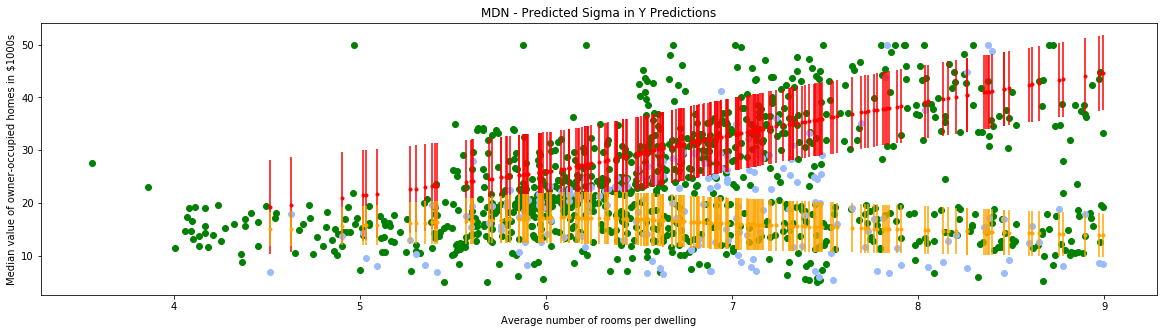

In [572]:
plt.figure(figsize=(20, 5))
plt.title('MDN - Predicted Sigma in Y Predictions')

plt.scatter(x_train, y_train, color='green')
plt.scatter(x_val, y_val, color=dot_color)
plt.errorbar(x_val, mdn_mu[:,0], yerr=np.sqrt(mdn_sigma[:,0])**2 , color='red', fmt='.'); 
plt.errorbar(x_val, mdn_mu[:,1], yerr=np.sqrt(mdn_sigma[:,1])**2 , color='orange', fmt='.'); 
plt.xlabel('Average number of rooms per dwelling')
plt.ylabel('Median value of owner-occupied homes in $1000s')
ax1.legend([r'Testing data','Predictions - kernel 1', 'Predictions - kernel 2', 'Predictions - kernel 3'], loc='upper left', );


We have predicted three different sources. Nevertheless, the red and green are not correct. We see that we only need one gaussian kernel not three.

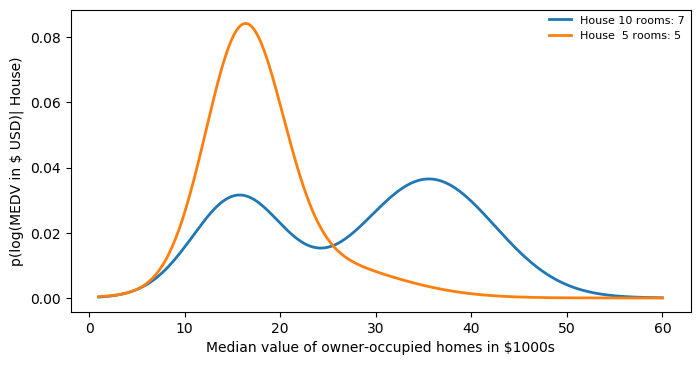

In [578]:
sns.color_palette("tab10")

def plot_house_dist(ax, index, col_index):
    mdn_alpha, mdn_mu, mdn_sigma = slice_parameter_vectors(mdn_.predict(x_val[index].reshape(1,-1)))

    gm = tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(probs=mdn_alpha),
            components_distribution=tfd.Normal(
                loc=mdn_mu,       
                scale=mdn_sigma))
    pyx = gm.prob(x)
    la = "House{:3d}".format(index) + ' rooms: ' +  str(int(x_val[house_idx]))
    ax.plot(x,pyx, alpha=1, color=sns.color_palette("tab10")[col_index], linewidth=2, label=la)
    
    
x = np.linspace(1,60,int(1e3))

fig = plt.figure(figsize=(8,4), dpi=100)
ax = plt.gca()

houses_index = [10, 5]
icol = 0
for house_idx in houses_index:
    plot_house_dist(ax, house_idx, icol)
    icol+=1

ax.set_xlabel('Median value of owner-occupied homes in $1000s')
ax.set_ylabel("p(log(MEDV in $ USD)| House)")
ax.legend(loc=0, borderaxespad=0.1, framealpha=1.0, fancybox=True, ncol=1, shadow=True, frameon=False, fontsize=8)

plt.show()

In [61]:
for house_idx in houses_index:
    print('House ' + str(house_idx) +  ': RM: ' +  str(x_val[house_idx]))

House 46: RM: 4.519
House 45: RM: 6.871


We have predicted 3 different gaussian distributions P(Y|X) for 4 different house types. (different number of rooms (RM) and % lower status population (LSTAT))

### Conclusions

* MDN are capable to adapt to multimodal distributions of P(Y|X) as opposite of the technique Exp.I 'Variance on the fly' that it is not able to accomodate this type of distribution.


* **We have validated the hypothesis that MDN are prone to overfitting**. This implies to run additional tests to properly select the hyperparameters.

* It can be a good solution for modelling a complex dataset. However **it has the difficulty of choosing an appropiate number of mixture components**. Finding the right number of kernels might be computational expensive. For example, in this experiment we have easily seen that 2 gaussian kernels might be enough but real datasets using multidimensional data may require a different testing strategy *(Explanation Note 1)


The **hypothesis** is that MDN will be capable of modelling the uncertainty better since it makes less assumptions about the initial data distribution. Nevertheless, one of the key problems of MDN is that the output of the network increase with the number of parameters which may cause overfitting problems [1]



*Explanation Note 1*

This conclusion comes from the fact that working with too many dimensions causes every observation in your dataset to appear equidistant from all the others. This related to the Curse-of-dimensionality [3]
This might be a real problem for choosing a proper number of kernel and parameters. According to this fact, we found the following two problems:

* (1) **Normally, high multidimensional datasets requires more parameters**. MDN exponentially increase the network output with the number of parameters.
* (2) **A high number of kernels might cause the network to be very unestable**. Different observations may belong to different clusters at the same time. 



### Future steps

(1) Try the implementation of MDN with ALD. Understand its differences and limitations. This analysis could help us to get a more simple and straightforward implementation of [UMAL](https://github.com/beeva/TEC_LAB-bayesian_probabilistic/blob/master/bayesian_deep_learning/uncertainty_estimation/umal/README.md).

(2) Propose an easy and generic implementation of on-the-fly using tensorflow probability library for MLE. 

(3) Extend the capabilities of MDN using different families of distribution instead of being restricted to only one. We could try with the Tensorflow function [tfd.Distribution](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Mixture) instead of [MixtureSameFamily](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/MixtureSameFamily) to avoid this restriction.

In order to implement this approach we have to play also with a different number of parameters in the loss function. Additionally, the output will change and jointly miniziming different parameters may lead to convergence problems.

### References

[1] Axel Brando, Jose A. Rodriguez-Serrano, Jordi Vitria, Alberto Rubio. "Modelling heterogeneous distributions with an Uncountable Mixture of Asymmetric Laplacians." Advances in Neural Information Processing Systems. 2019.

[2] https://github.com/oborchers/Medium_Repo

[3] https://en.wikipedia.org/wiki/Curse_of_dimensionality

[4] [StatQuest: Probability vs Likelihood](https://www.youtube.com/watch?v=pYxNSUDSFH4)

[5] [Maximum Likelihood For the Normal Distribution, step-by-step!](https://www.youtube.com/watch?v=Dn6b9fCIUpM)